# The backward pass (in theory)

So, we want to compute derivatives. To make things concrete, we'll use our running example, the logistic regression.

In mathematical terms, we have the function

$$
f(a, b, x) = \sigma(a x + b),
$$

where $ x $ is the input, and $ a, b $ are the model parameters. Our ultimate goal is to compute the partial derivatives $ \frac{\partial f}{\partial a}(x) $ and $ \frac{\partial f}{\partial b}(x) $.

How to do that? Experienced calculus users are able to immediately reply

$$
\begin{align*}
\frac{\partial f}{\partial a}(x) &= x \sigma^\prime(ax + b), \\
\frac{\partial f}{\partial b}(x) &= \sigma^\prime(ax + b),
\end{align*}
$$

but how was that obtained? With the *chain rule*, one of the most important results in mathematics. Let's state this before we move on with our example. Single variable first, multiple variables second.

````{prf:theorem} Chain rule, single variable.

Let $ f, g: \mathbb{R} \to \mathbb{R} $ be two differentiable functions, and let $ h(x) = f(g(x)) $. Then

$$
\Big( f\big(g(x)\big) \Big)^\prime = f^\prime\big(g(x)\big) g^\prime(x).
$$

or in other words,

$$
\frac{dh}{dx} = \frac{df}{dg} \frac{dg}{dx},
$$
````

In English, this means that the derivative of the composite function equals the product of the components' derivatives, evaluated at the appropriate locations.

````{prf:remark} Abuse of notation.
If you are an attentive reader, perhaps you've noticed that there's a discrepancy between the notations $ f^\prime(g(x)) $, $ \frac{df}{dx} $, $ \frac{df}{dg} $, and so on.

For instance, $ \frac{df}{dx} $ and $ \frac{df}{dg} $ doesn't make sense, as the function $ f $ is univariate, defined in terms of an arbitrary variable $ x $. So, what's $ \frac{df}{dg} $? Let's clear this up once and for all, as this is going to be important.

According to the chain rule, the derivative of the composed function $ f(g(x)) $ is

$$
\Big( f\big(g(x)\big) \Big)^\prime = f^\prime\big(g(x)\big) g^\prime(x),
$$

in other words, the derivative function $ f^\prime $ is evaluated at $ g(x) $. To avoid writing monstrosities like $ \frac{df}{dx}(g(x)) $, we rather think of $ f $ as defined in terms of the variable $ g = g(x) $, and simply write $ \frac{df}{dg} $, which is shorthand for

$$
\frac{df}{dg} = \frac{df}{dx}(g(x)) = f^\prime(g(x)).
$$
````

For multiple variables, the chain rule goes like the following.

````{prf:theorem} Chain rule, multiple variables.

Let $ f: \mathbb{R}^m \to \mathbb{R} $ be a function of $ m $ variables, let $ g_1, \dots, g_m: \mathbb{R}^n \to \mathbb{R} $, and define $ h: \mathbf{R}^n \to \mathbb{R} $ by

$$
h(\mathbf{x}) = f\big( g_1(\mathbf{x}), \dots, g_m(\mathbf{x}) \big), \quad \mathbf{x} = (x_1, \dots, x_n).
$$

Then

$$
\frac{\partial h}{\partial x_i} = \sum_{j=1}^{m} \frac{\partial f}{\partial g_j} \frac{\partial g_j}{\partial x_i}
$$

````

As we've seen that before $ f $ is a composite function, built from the blocks

$$
\begin{align*}
c(a, x) &= a x, \\
y(c, b) &= c + b, \\
\sigma(y) &= \frac{1}{1 + e^{-y}}
\end{align*}
$$

that yield

$$
f(a, b, x) = \sigma\Big(y\big(c(a, x), b\big) \Big).
$$

Thus,

$$
\begin{align*}
\frac{\partial f}{\partial a} &= \frac{d\sigma}{dx} \frac{\partial y}{\partial a} \\
&= \frac{d\sigma}{dx} \bigg( \frac{\partial y}{\partial c} \frac{\partial c}{\partial a} + \frac{\partial y}{\partial b} \frac{\partial b}{\partial a} \bigg) \\
&= \sigma^\prime(ax + b) \bigg( 1 \cdot x + 1 \cdot 0 \bigg) \\
&= x \sigma^\prime(ax + b),
\end{align*}
$$

as we've seen it earlier.

Because of the layered structure of neural networks, the chain rule will be our bread and butter in calculating the derivatives. Now that we understand how it works, let's see what they mean in the context of computational graphs!

## The chain rule and computational graphs

Let's go back to square one and consider the composite function $ f(g(x)) $. In computational graph terms, we prefer to work with *variables*, not functions. That is, instead of $ f(g(x)) $, we have the variables `x`, `g`, `f`, the elements of our computations.

Here's how this simple graph looks.

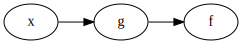

In [1]:
from graphviz import Digraph


digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "x")
digraph.node("g", "g")
digraph.node("f", "f")
digraph.edges(["xg", "gf"])

digraph

````{prf:remark} Abuse of notation, part 2.

Note that in the above computational graph, `g` is not the mathematical function $ g $, and neither does `f`. The variables are the results of the computations defined by the functions. Mathematically speaking, we have
* the input $ x $,  
* the variable $ f = f(x) $,  
* and the variable $ g = g(f) $.

In principle, we are not allowed to designate the same symbol to different variables, but adding another set of symbols would be cumbersome. Thus, we take a hit in precision to gain a bit of simplicity.
````

In the language of computational graphs, the chain rule expresses the derivative of the terminal node `f` with respect to the initial node `x`. Essentially, we compute the following graph.

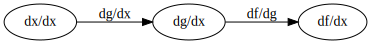

In [2]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "dx/dx")
digraph.node("g", "dg/dx")
digraph.node("f", "df/dx")
digraph.edge("x", "g", label="dg/dx")
digraph.edge("g", "f", label="df/dg")

digraph

It's quite overloaded with information. Let me explain. In this derivative graph,
* a node corresponds the derivative of the original node with respect to the initial node `x`,  
* and an edge corresponds to the derivative of its end-node with respect to its start node.

Using the chain rule, we obtain the values in the nodes by multiplying together all the edges leading up to it: $ \frac{df}{dx} = \frac{df}{dg} \frac{dg}{dx} $.

Because we progress from the initial node `x` to the terminal node `f`, this is called *forward-mode differentiation*. Accordingly, the
* derivatives represented by the nodes are called the *forward derivatives*,
* and the derivatives on the edge are called *local derivatives*.

To get a firm grasp on how forward-mode differentiation works, let's put one more node and consider the graph given by $ h(f(g(x))) $:

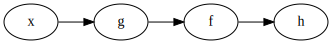

In [3]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "x")
digraph.node("g", "g")
digraph.node("f", "f")
digraph.node("h", "h")
digraph.edges(["xg", "gf", "fh"])

digraph

To check your understanding, try to carry through the previous process:
* sketch the derivative graph,
* and compute the derivatives of the nodes with respect to the initial node `x`.

Welcome back! This is what you should have got:

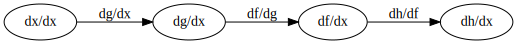

In [4]:
digraph = Digraph()
digraph.attr(rankdir='LR')

digraph.node("x", "dx/dx")
digraph.node("g", "dg/dx")
digraph.node("f", "df/dx")
digraph.node("h", "dh/dx")
digraph.edge("x", "g", label="dg/dx")
digraph.edge("g", "f", label="df/dg")
digraph.edge("f", "h", label="dh/df")

digraph

To confirm, the iterated application of the chain rule gives

$$
\begin{align*}
\frac{dh}{dx} &= \frac{dh}{df} \frac{df}{dx} \\
&= \frac{dh}{df} \frac{df}{dg} \frac{dg}{dx}.
\end{align*}
$$

Now you understand why is the chain rule called the *chain* rule! The next step is to study it in a multivariable context.

### The multivariable case

Let's turn the difficulty dial up a notch and consider the function

$$
f\big(g_1(x), g_2(x)\big),
$$

which is composed from

* a bivariate function $ f: \mathbb{R}^2 \to \mathbb{R} $,
* and two univariate functions $ g_1, g_2: \mathbb{R} \to \mathbb{R} $.

Sketching up its graph, we obtain the following:

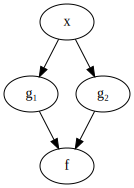

In [5]:
digraph = Digraph()

digraph.node("x")
digraph.node("g₁")
digraph.node("g₂")
digraph.node("f")
digraph.edges([("x", "g₁"), ("x", "g₂"),
               ("g₁", "f"), ("g₂", "f"),])


digraph

Again, our goal is to calculate $ \frac{\partial f}{\partial x} $. To do that, we employ the (multivariate) chain rule

$$
\frac{\partial f}{\partial x} = \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial x} + \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial x},
$$

or in computational graph terms:

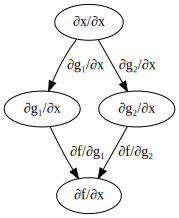

In [6]:
digraph = Digraph()

nodes = ["x", "g₁", "g₂", "f"]
edges = [("x", "g₁"), ("x", "g₂"), ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v, f"∂{v}/∂x")

for u, v in edges:
    digraph.edge(u, v, f"∂{v}/∂{u}")

digraph

In this case, the derivative $ \frac{\partial f}{\partial x} $ is obtained via forward-mode differentiation; that is,

1. computing the local derivatives on the edges,
2. taking a path from the initial node `x` to the terminal node `f`,
3. multiplying together all intermediate derivatives along the edges,
4. and summing the products for all paths.

Take a look at the expression

$$
\frac{\partial f}{\partial x} = \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial x} + \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial x},
$$

where the first term $ \frac{\partial f}{\partial g_1} \frac{\partial g_1}{\partial x} $ corresponds to the left path, while $ \frac{\partial f}{\partial g_2} \frac{\partial g_2}{\partial x} $ corresponds to the right one.

Now, it's time to put a twist into everything that we've learned so far regarding the chain rule!

### The problems with forward-mode differentiation

Let's increase the complexity one more time, and consider the computational graph defined by the expression

$$
f\big( g_1(x_1, x_2), g_2(x_1, x_2) \big),
$$

which looks like the following.

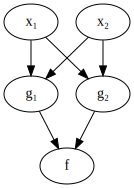

In [7]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

As there are two initial nodes `x₁` and `x₂`, we would like to compute both $ \frac{\partial f}{\partial x_1} $ and $ \frac{\partial f}{\partial x_2} $. This presents us with a problem, as now, we have to compute two graphs:

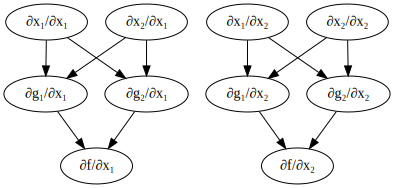

In [8]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v, label=f"∂{v}/∂x₁")

for u, v in edges:
    digraph.edge(u, v)

offset = " "
for v in nodes:
    digraph.node(v + offset, label=f"∂{v}/∂x₂")

edges_offset = [(u + offset, v + offset) for u, v in edges]
for u, v in edges_offset:
    digraph.edge(u, v)

digraph

(I have omitted the edge labels for clarity.)

Now, our computational cost has increased twofold. For $ n $ input variables (or features), the increase is $ n $-fold. In practice, the number of input variables is in the tens of thousands: for instance, consider a $ 256 \times 256 $ image, containing $ 65536 $ pixels in total. If we were to calculate the derivatives this way, this is a significant issue.

That's only the tip of the iceberg. Next, consider an analogous computational graph, coming from the expression

$$
f\big( g_1(x_1, x_2, x_3), g_2(x_1, x_2, x_3), g_1(x_1, x_2, x_3) \big).
$$

This time, there are three input nodes (`x₁`, `x₂`, `x₃`) and three middle nodes (`g₁`, `g₂`, `g₃`).

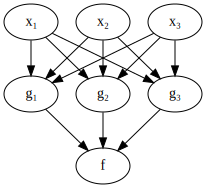

In [9]:
digraph = Digraph()

nodes = ["x₁", "x₂", "x₃", "g₁", "g₂", "g₃", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"), ("x₁", "g₃"),
         ("x₂", "g₁"), ("x₂", "g₂"), ("x₂", "g₃"),
         ("x₃", "g₁"), ("x₃", "g₂"), ("x₃", "g₃"),
         ("g₁", "f"), ("g₂", "f"), ("g₃", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

The number of paths from initial to terminal nodes increase dramatically with the addition of new nodes. Compared to $ f\big( g_1(x_1, x_2), g_2(x_1, x_2) \big) $, where we had only $ 2 \cdot 2 = 4 $ paths, this time, we have $ 3 \cdot 3 = 9 $.

This gets exponentially worse if we add another layer. Consider the following computationak graph. (I don't even want to show you the expression it came from, let alone to type it.)

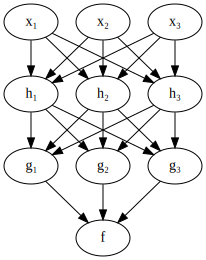

In [10]:
digraph = Digraph()

nodes = ["x₁", "x₂", "x₃", 
         "h₁", "h₂", "h₃",
         "g₁", "g₂", "g₃",
         "f"]
edges = [("x₁", "h₁"), ("x₁", "h₂"), ("x₁", "h₃"),
         ("x₂", "h₁"), ("x₂", "h₂"), ("x₂", "h₃"),
         ("x₃", "h₁"), ("x₃", "h₂"), ("x₃", "h₃"),
         ("h₁", "g₁"), ("h₁", "g₂"), ("h₁", "g₃"),
         ("h₂", "g₁"), ("h₂", "g₂"), ("h₂", "g₃"),
         ("h₃", "g₁"), ("h₃", "g₂"), ("h₃", "g₃"),
         ("g₁", "f"), ("g₂", "f"), ("g₃", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

The number of paths to sum over have gone from $ 3^2 $ to $ 3^3 = 27 $. This is the dreaded exponential increase.

What can we do? Enter the backward-mode differentiation.

## Backward-mode differentiation

Let's go back to the example $ f\big( g_1(x_1, x_2), g_2(x_1, x_2) \big) $. Here's its graph.

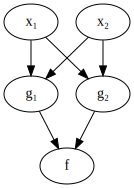

In [11]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v)

digraph.edges(edges)

digraph

Previously, we have obtained $ \frac{\partial f}{\partial x_1} $ and $ \frac{\partial f}{\partial x_2} $ by computing two graphs:

* one with the nodes representing the partial derivatives with respect to $ x_1 $,
* and another with nodes representing the partial derivatives with respect to $ x_2 $.

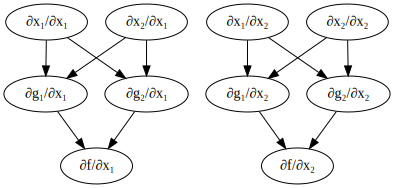

In [12]:
digraph = Digraph()

nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(v, label=f"∂{v}/∂x₁")

for u, v in edges:
    digraph.edge(u, v)

offset = " "
for v in nodes:
    digraph.node(v + offset, label=f"∂{v}/∂x₂")

edges_offset = [(u + offset, v + offset) for u, v in edges]
for u, v in edges_offset:
    digraph.edge(u, v)

digraph

Let's turn it upside down! Instead of populating the graph with $ \frac{\partial v}{\partial x_i} $ for the node $ v $, we'll compute the derivatives $ \frac{\partial f}{\partial v} $:

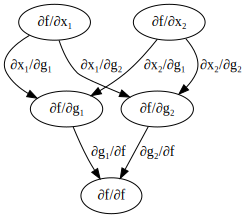

In [20]:
digraph = Digraph()
make_label = lambda x, y: f"∂{x}/∂{y}"


nodes = ["x₁", "x₂", "g₁", "g₂", "f"]
edges = [("x₁", "g₁"), ("x₁", "g₂"),
         ("x₂", "g₁"), ("x₂", "g₂"),
         ("g₁", "f"), ("g₂", "f")]

for v in nodes:
    digraph.node(make_label("f", v))

for u, v in edges:
    digraph.edge(make_label("f", u), make_label("f", v), label=make_label(u, v))

digraph